# Preamble

In [1]:
from pathlib import Path
import shutil
import json
import pandas as pd
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

from fastai.dataset import *
from fastai.conv_learner import ConvLearner

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [25]:
PATH = Path('D:/msc/kaggle_data/whales')
IMG_PATH = 'train/new_whale'

# Get dataset to reasonable form

In [8]:
train = json.load((PATH/'some_whales_in_boxes.json').open())
train_df = pd.DataFrame(train)
train_df = train_df[['External ID', 'Label']]
train_df = train_df[train_df['Label'] != 'Skip']
train_df['Box'] = train_df.apply( lambda x: x['Label']['Tail'][0], axis=1)

In [9]:
def init2bb(l):
    return([min(l[0]['y'], l[1]['y'], l[2]['y'], l[3]['y']),
     min(l[0]['x'], l[1]['x'], l[2]['x'], l[3]['x']),
     max(l[0]['y'], l[1]['y'], l[2]['y'], l[3]['y']),
     max(l[0]['x'], l[1]['x'], l[2]['x'], l[3]['x'])])

In [10]:
train_df['BB'] = train_df.apply( lambda x: init2bb(x['Box']), axis=1)

# Rewrite the fastai display functions and check that boxes make sense

In [4]:
def show_img(im, figsize = None, ax = None):
    if not ax: fig, ax = plt.subplots(figsize = figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [5]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw,foreground='black'), patheffects.Normal()])

In [6]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white',lw=2))
    draw_outline(patch,4)

In [7]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [8]:
def draw_idx(i):
    ax = show_img(open_image(IMG_PATH/train_df.iloc[i]['External ID']))
    b = bb_hw(train_df.iloc[i]['BB'])
    draw_rect(ax, b)

# Train a resnet of some sort

## Make csv

In [18]:
csv_df = train_df[['External ID']]

In [19]:
csv_df.columns = ['fn']

In [20]:
csv_df['bbox'] = train_df['BB'].apply(lambda x: ' '.join(str(p) for p in x))

C:\Users\msc12\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
csv_df.to_csv(PATH/'tmp/bb.csv', index=False)

## Train a net

In [9]:
f_model=resnet34
sz=224
bs=8

In [90]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        #RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.1,0.1, tfm_y=tfm_y)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, 'train/new_whale', PATH/'tmp/bb.csv', tfms = tfms, continuous = True, bs=bs, test_name='train_full')

In [91]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [18]:
learn.lr_find(1e-5, 100)

 76%|██████████████████████████████████████████████████████▋                 | 41/54 [00:04<00:01,  8.74it/s, loss=380]


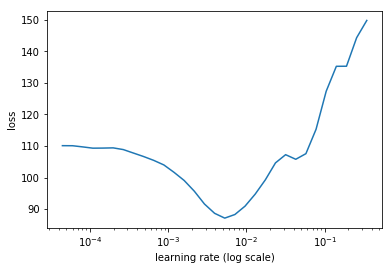

In [19]:
learn.sched.plot(5)

In [45]:
lr =2e-3

In [46]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      25.10607   12.709703 
    1      15.199393  8.855484                                                                                         
    2      11.079646  8.379404                                                                                         
    3      10.697505  9.56212                                                                                          
    4      10.380302  8.456229                                                                                         
    5      8.456867   8.052256                                                                                         
    6      7.103077   7.277046                                                                                         



[7.277046056551354]

In [87]:
lrs = np.array([lr/100,lr/10,lr])

In [88]:
learn.freeze_to(-2)

In [89]:
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      14.209827  11.710927 
    1      13.618609  10.790402                                                                                        
    2      10.717842  6.895372                                                                                         
    3      10.781602  8.280161                                                                                         
    4      10.115367  8.234286                                                                                         
    5      8.11987    5.758921                                                                                         
    6      6.272546   5.264782                                                                                         
    7      8.852444   8.481258                                                                                         
    8  

[3.8327079309481324]

In [92]:
#learn.save('reg4')
learn.load('reg4')

In [160]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds_1 = to_np(learn.model(VV(x)))

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


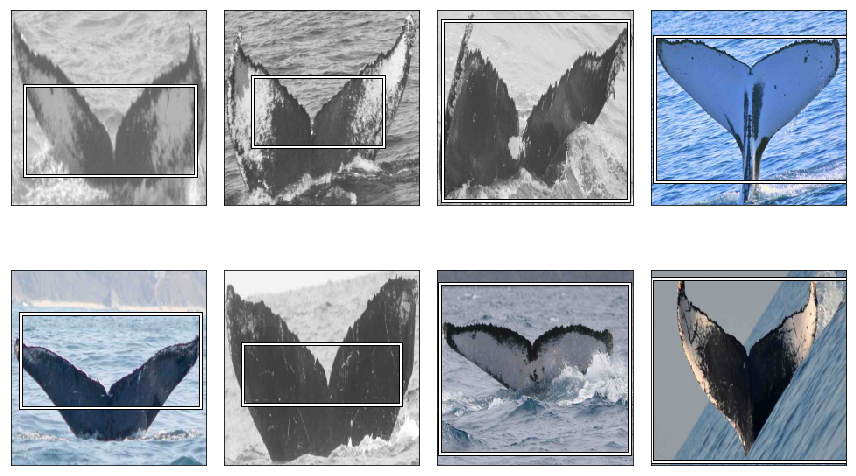

In [167]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    #ax = show_img(ima[int(preds_1[i][0]):int(preds_1[i][2]), int(preds_1[i][1]):int(preds_1[i][3])], ax=ax)
    as = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

# Crop the images

## Get all train images into same folder (same for validation)

In [16]:
FULL_TRAIN =  PATH/'train_full'
#FULL_TRAIN.mkdir()
for dr in (PATH/'train').iterdir():
    for file in dr.iterdir():
        shutil.copy(str(file), str(FULL_TRAIN))

In [134]:
FULL_VALID =  PATH/'validation_full'
#FULL_VALID.mkdir()
for dr in (PATH/'validation').iterdir():
    for file in dr.iterdir():
        shutil.copy(str(file), str(FULL_VALID))

## Make a ConvLearner for each case with weights from above and respective test set

In [85]:
train_data = ImageClassifierData.from_csv(PATH, IMG_PATH, PATH/'tmp/bb.csv', tfms=tfms, continuous = True, test_name='train_full')
train_cropper = ConvLearner.pretrained(f_model, train_data, custom_head=head_reg4)
train_cropper.load('reg4')
train_boxs = train_cropper.predict(is_test=True)

In [220]:
train_boxs = np.clip(train_boxs,0,sz)

In [33]:
validation_data = ImageClassifierData.from_csv(PATH, IMG_PATH, PATH/'tmp/bb.csv', tfms=tfms, continuous = True, test_name='validation_full')
validation_cropper = ConvLearner.pretrained(f_model, validation_data, custom_head=head_reg4)
validation_cropper.load('reg4')
validation_boxs = validation_cropper.predict(is_test=True)

In [222]:
validation_boxs = np.clip(validation_boxs,0,sz)

In [34]:
test_data = ImageClassifierData.from_csv(PATH, IMG_PATH, PATH/'tmp/bb.csv', tfms=tfms, continuous = True, test_name='test')
test_cropper = ConvLearner.pretrained(f_model, test_data, custom_head=head_reg4)
test_cropper.load('reg4')
test_boxs = test_cropper.predict(is_test=True)

In [223]:
test_boxs = np.clip(test_boxs,0,sz)

## Save results to new folders

In [221]:
TRAIN_CROPPED_PATH = PATH/'train_cropperd'
#TRAIN_CROPPED_PATH.mkdir()
for dr in (PATH/'train').iterdir():
    #(TRAIN_CROPPED_PATH/dr.name).mkdir()
    for file in dr.iterdir():
        fn='train_full\\'+file.name
        ima = open_image(PATH/fn)
        shape = ima.shape
        idx = np.where(np.array(train_data.test_ds.fnames) == fn)[0][0]
        pred = train_boxs[idx]
        cropped_ima = ima[int(shape[0]*pred[0]/sz):int(shape[0]*pred[2]/sz), int(shape[1]*pred[1]/sz):int(shape[1]*pred[3]/sz)]
        cv2.imwrite(str(TRAIN_CROPPED_PATH/dr.name/file.name), cv2.cvtColor((cropped_ima*255).astype(np.uint8), cv2.COLOR_RGB2BGR))

In [224]:
VAL_CROPPED_PATH = PATH/'validation_cropperd'
VAL_CROPPED_PATH.mkdir()
for dr in (PATH/'validation').iterdir():
    (VAL_CROPPED_PATH/dr.name).mkdir()
    for file in dr.iterdir():
        fn='validation_full\\'+file.name
        ima = open_image(PATH/fn)
        shape = ima.shape
        idx = np.where(np.array(validation_data.test_ds.fnames) == fn)[0][0]
        pred = validation_boxs[idx]
        cropped_ima = ima[int(shape[0]*pred[0]/sz):int(shape[0]*pred[2]/sz), int(shape[1]*pred[1]/sz):int(shape[1]*pred[3]/sz)]
        cv2.imwrite(str(VAL_CROPPED_PATH/dr.name/file.name), cv2.cvtColor((cropped_ima*255).astype(np.uint8), cv2.COLOR_RGB2BGR))

In [229]:
TEST_CROPPED_PATH = PATH/'test_cropperd'
#TEST_CROPPED_PATH.mkdir()
for file in (PATH/'test').iterdir():
    fn='test\\'+file.name
    ima = open_image(PATH/fn)
    shape = ima.shape
    idx = np.where(np.array(test_data.test_ds.fnames) == fn)[0][0]
    pred = test_boxs[idx]
    cropped_ima = ima[int(shape[0]*pred[0]/sz):int(shape[0]*pred[2]/sz), int(shape[1]*pred[1]/sz):int(shape[1]*pred[3]/sz)]
    cv2.imwrite(str(TEST_CROPPED_PATH/file.name), cv2.cvtColor((cropped_ima*255).astype(np.uint8), cv2.COLOR_RGB2BGR))